In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_02 import *
import torch.nn.functional as F

## Initial setup

### Data

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=1786)

In [3]:
mpl.rcParams['image.cmap'] = 'gray'

In [4]:
x_train,y_train,x_valid,y_valid = get_data()

In [5]:
n,m = x_train.shape
c = y_train.max()+1
nh = 50

In [6]:
#using pytorch code here now
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in,nh), nn.ReLU(), nn.Linear(nh,n_out)] #in Model, you define your layer orders
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [7]:
model = Model(m, nh, 10)

In [8]:
pred = model(x_train)

### Cross entropy loss

First, we will need to compute the softmax of our activations. This is defined by:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{e^{x_{0}} + e^{x_{1}} + \cdots + e^{x_{n-1}}}$$

or more concisely:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{\sum_{0 \leq j \leq n-1} e^{x_{j}}}$$ 

In practice, we will need the log of the softmax when we calculate the loss.

In [13]:
pred.shape

torch.Size([50000, 10])

In [9]:
def log_softmax(x): return (x.exp()/(x.exp().sum(-1,keepdim=True))).log()
#x.exp().sum(-1) being broadcasted to x.exp()

In [23]:
def log_softmax(x): return (x.exp()/(x.exp().sum(-1).unsqueeze(-1))).log()

In [10]:
sm_pred = log_softmax(pred)

In [30]:
sm_pred.shape

torch.Size([50000, 10])

In [22]:
pred.sum(1).shape

torch.Size([50000])

In [21]:
pred.sum(1,keepdim=True).shape

torch.Size([50000, 1])

The cross entropy loss for some target $x$ and some prediction $p(x)$ is given by:

$$ -\sum x\, \log p(x) $$

But since our $x$s are 1-hot encoded, this can be rewritten as $-\log(p_{i})$ where i is the index of the desired target.

This can be done using numpy-style [integer array indexing](https://docs.scipy.org/doc/numpy-1.13.0/reference/arrays.indexing.html#integer-array-indexing). Note that PyTorch supports all the tricks in the advanced indexing methods discussed in that link.

In [9]:
y_train[:3]

tensor([5, 0, 4])

In [27]:
sm_pred[[0,1,2], [5,0,4]] #indexing technique to pick out 0,5; 1,0; 2;4 from sm_pred

tensor([-2.4652, -2.3767, -2.3021], grad_fn=<IndexBackward>)

In [28]:
y_train.shape[0]

50000

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=2081)

In [11]:
def nll(input, target): return -input[range(target.shape[0]), target].mean()

In [12]:
loss = nll(sm_pred, y_train)

In [13]:
loss

tensor(2.3087, grad_fn=<NegBackward>)

Note that the formula 

$$\log \left ( \frac{a}{b} \right ) = \log(a) - \log(b)$$ 

gives a simplification when we compute the log softmax, which was previously defined as `(x.exp()/(x.exp().sum(-1,keepdim=True))).log()`

==>
`x.exp().log() - x.exp().sum(-1,keepdim=True).log()`

==>`x - x.exp().sum(-1,keepdim=True).log()`

In [14]:
def log_softmax(x): return x - x.exp().sum(-1,keepdim=True).log()

In [15]:
test_near(nll(log_softmax(pred), y_train), loss)

Then, there is a way to compute the log of the sum of exponentials in a more stable way, called the [LogSumExp trick](https://en.wikipedia.org/wiki/LogSumExp). The idea is to use the following formula:

$$\log \left ( \sum_{j=1}^{n} e^{x_{j}} \right ) = \log \left ( e^{a} \sum_{j=1}^{n} e^{x_{j}-a} \right ) = a + \log \left ( \sum_{j=1}^{n} e^{x_{j}-a} \right )$$

where a is the maximum of the $x_{j}$.

In [16]:
import torch

In [46]:
j = torch.tensor([[1,2,3,4],[2,3,4,5]])

In [47]:
j

tensor([[1, 2, 3, 4],
        [2, 3, 4, 5]])

In [48]:
j.max(-1)

torch.return_types.max(
values=tensor([4, 5]),
indices=tensor([3, 3]))

In [17]:
def logsumexp(x):  #numerical stability tricks;
    m = x.max(-1)[0]
    return m + (x-m[:,None]).exp().sum(-1).log()

This way, we will avoid an overflow when taking the exponential of a big activation. In PyTorch, this is already implemented for us. 

In [18]:
test_near(logsumexp(pred), pred.logsumexp(-1))

So we can use it for our `log_softmax` function.

In [19]:
def log_softmax(x): return x - x.logsumexp(-1,keepdim=True)

In [20]:
test_near(nll(log_softmax(pred), y_train), loss)

Then use PyTorch's implementation.

In [21]:
test_near(F.nll_loss(F.log_softmax(pred, -1), y_train), loss)

In PyTorch, `F.log_softmax` and `F.nll_loss` are combined in one optimized function, `F.cross_entropy`.

In [22]:
test_near(F.cross_entropy(pred, y_train), loss)

## Basic training loop

Basically the training loop repeats over the following steps:
- get the output of the model on a batch of inputs
- compare the output to the labels we have and compute a loss
- calculate the gradients of the loss with respect to every parameter of the model
- update said parameters with those gradients to make them a little bit better

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=2542)

In [26]:
loss_func = F.cross_entropy

In [23]:
#export
def accuracy(out, yb): return (torch.argmax(out, dim=1)==yb).float().mean()

In [24]:
bs=64                  # batch size

xb = x_train[0:bs]     # a mini-batch from x
preds = model(xb)      # predictions
preds[0], preds.shape

(tensor([ 0.0902,  0.1025,  0.0284, -0.0219,  0.1358,  0.0809,  0.0198, -0.1400,
          0.1456, -0.0470], grad_fn=<SelectBackward>), torch.Size([64, 10]))

In [27]:
yb = y_train[0:bs]
loss_func(preds, yb)

tensor(2.3078, grad_fn=<NllLossBackward>)

In [28]:
accuracy(preds, yb)

tensor(0.1406)

In [58]:
n

50000

In [29]:
lr = 0.5   # learning rate
epochs = 1 # how many epochs to train for

In [30]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
#         set_trace()
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        loss = loss_func(model(xb), yb)

        loss.backward()
        with torch.no_grad(): 
            # because the following calcuations are not used to calculate gradient anymore
            # they are used to update gradient so no tracking wanted. 
            for l in model.layers:
                if hasattr(l, 'weight'): 
                    #since Relu has no weight attribute, so hasattr() filters it out
                    l.weight -= l.weight.grad * lr
                    l.bias   -= l.bias.grad   * lr
                    l.weight.grad.zero_()
                    l.bias  .grad.zero_()

In [31]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0494, grad_fn=<NllLossBackward>), tensor(1.))

## Using parameters and optim

### Parameters

Use `nn.Module.__setattr__` and move relu to functional:

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=2818)

In [32]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()    #init code to allow refactoring / simplification of code
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
        
    def __call__(self, x): return self.l2(F.relu(self.l1(x)))

In [33]:
model = Model(m, nh, 10)

In [34]:
for name,l in model.named_children(): print(f"{name}: {l}")

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)


In [66]:
model  #calling the __repr__ of nn.Module class

Model(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
)

In [67]:
model.l1

Linear(in_features=784, out_features=50, bias=True)

In [35]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1)//bs + 1):
            start_i = i*bs
            end_i = start_i+bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            loss = loss_func(model(xb), yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters(): p -= p.grad * lr
                model.zero_grad()

In [36]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0674, grad_fn=<NllLossBackward>), tensor(1.))

Behind the scenes, PyTorch overrides the `__setattr__` function in `nn.Module` so that the submodules you define are properly registered as parameters of the model.

In [59]:
class DummyModule():
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
        
    def __setattr__(self,k,v):
        if not k.startswith("_"): self._modules[k] = v
        super().__setattr__(k,v)
        
    def __repr__(self): return f'{self._modules}'
    
    def parameters(self):
        for l in self._modules.values():
            for p in l.parameters(): yield p  #good for interator usage due to continuation after each yield

In [60]:
mdl = DummyModule(m,nh,10)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [63]:
mdl._modules

{'l1': Linear(in_features=784, out_features=50, bias=True),
 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [68]:
[o.shape for o in mdl.parameters()]

[torch.Size([50, 784]),
 torch.Size([50]),
 torch.Size([10, 50]),
 torch.Size([10])]

### Registering modules

We can use the original `layers` approach, but we have to register the modules.

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=2997)

In [37]:
layers = [nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10)]

In [38]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i,l in enumerate(self.layers): self.add_module(f'layer_{i}', l)
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [39]:
model = Model(layers)

In [76]:
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

### nn.ModuleList

`nn.ModuleList` does this for us.

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=3173)

In [40]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [41]:
model = SequentialModel(layers)

In [42]:
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [43]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.2087, grad_fn=<NllLossBackward>), tensor(0.9375))

### nn.Sequential

`nn.Sequential` is a convenient class which does the same as the above:

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=3199)

In [44]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [45]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0418, grad_fn=<NllLossBackward>), tensor(1.))

In [88]:
nn.Sequential??

In [100]:
model.__len__()

3

In [89]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

### optim

Let's replace our previous manually coded optimization step:

```python
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()
```

and instead use just:

```python
opt.step()
opt.zero_grad()
```

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=3278)

In [46]:
class Optimizer():
    def __init__(self, params, lr=0.5): self.params , self.lr = list(params) , lr
        
    def step(self):
        with torch.no_grad():#not need to track grad of update operations
            for p in self.params: p -= p.grad * lr

    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()
            # didn't use model.zero_grad because sometimes unfreeze of portion of layers, we want only
            # those to be included

In [47]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [48]:
opt = Optimizer(model.parameters())

In [105]:
1//2

0

In [49]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1): # dealt with edge case where n = bs;
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [50]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss,acc

(tensor(0.4949, grad_fn=<NllLossBackward>), tensor(0.8125))

PyTorch already provides this exact functionality in `optim.SGD` (it also handles stuff like momentum, which we'll look at later - except we'll be doing it in a more flexible way!)

In [51]:
#export
from torch import optim

In [108]:
optim.SGD.step??

In [52]:
def get_model():
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
    return model, optim.SGD(model.parameters(), lr=lr)

In [53]:
model,opt = get_model()
loss_func(model(xb), yb)

tensor(2.2840, grad_fn=<NllLossBackward>)

In [54]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [112]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss,acc

(tensor(0.0690, grad_fn=<NllLossBackward>), tensor(1.))

Randomized tests can be very useful.

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=3442)

In [113]:
assert acc>0.7

## Dataset and DataLoader

### Dataset

It's clunky to iterate through minibatches of x and y values separately:

```python
    xb = x_train[start_i:end_i]
    yb = y_train[start_i:end_i]
```

Instead, let's do these two steps together, by introducing a `Dataset` class:

```python
    xb,yb = train_ds[i*bs : i*bs+bs]
```

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=3578)

In [55]:
#export
class Dataset():
    def __init__(self, x, y): self.x,self.y = x,y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i],self.y[i]
    # When you evaluate a[i] Python calls a.__getitem__(i)

In [56]:
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
assert len(train_ds)==len(x_train)
assert len(valid_ds)==len(x_valid)

In [57]:
type(train_ds) , type(x_train)

(__main__.Dataset, torch.Tensor)

In [58]:
xb,yb = train_ds[0:5]
assert xb.shape==(5,28*28)
assert yb.shape==(5,)  #why does it need a comma there?
xb,yb

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([5, 0, 4, 1, 9]))

In [125]:
yb.shape, xb.shape

(torch.Size([5]), torch.Size([5, 784]))

In [122]:
(5,)==(5,0)

False

In [59]:
model,opt = get_model()

In [60]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        xb,yb = train_ds[i*bs : i*bs+bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [61]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.0520, grad_fn=<NllLossBackward>), tensor(1.))

### DataLoader

Previously, our loop iterated over batches (xb, yb) like this:

```python
for i in range((n-1)//bs + 1):
    xb,yb = train_ds[i*bs : i*bs+bs]
    ...
```

Let's make our loop much cleaner, using a data loader:

```python
for xb,yb in train_dl:
    ...
```

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=3674)

In [62]:
class DataLoader():
    def __init__(self, ds, bs): self.ds,self.bs = ds,bs
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs): yield self.ds[i:i+self.bs]
            
            # when for x , y is called, behind the scene in python:
            # __iter__ is called

In [63]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [64]:
xb,yb = next(iter(valid_dl))
assert xb.shape==(bs,28*28)
assert yb.shape==(bs,)

tensor(3)

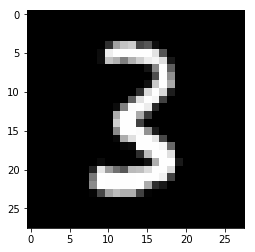

In [65]:
plt.imshow(xb[0].view(28,28))
yb[0]

In [66]:
model,opt = get_model()

In [67]:
def fit():
    for epoch in range(epochs):
        for xb,yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

In [69]:
fit()

In [70]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.1766, grad_fn=<NllLossBackward>), tensor(0.9375))

### Random sampling

We want our training set to be in a random order, and that order should differ each iteration. But the validation set shouldn't be randomized.

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=3942)

In [71]:
class Sampler():
    def __init__(self, ds, bs, shuffle=False):
        self.n,self.bs,self.shuffle = len(ds),bs,shuffle
        
    def __iter__(self):
        self.idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
        for i in range(0, self.n, self.bs): yield self.idxs[i:i+self.bs]

In [144]:
idxs=torch.randperm(3)

In [145]:
idxs

tensor([1, 0, 2])

In [146]:
idxs[0]

tensor(1)

In [149]:
small_ds = Dataset(*train_ds[:10])

AttributeError: 'Dataset' object has no attribute 'shape'

In [154]:
s = Sampler(small_ds,3,False)
[o for o in s]

[tensor([0, 1, 2]), tensor([3, 4, 5]), tensor([6, 7, 8]), tensor([9])]

In [155]:
s = Sampler(small_ds,3,True)
[o for o in s]

[tensor([7, 4, 2]), tensor([9, 5, 8]), tensor([0, 6, 1]), tensor([3])]

In [159]:
train_ds[1] # it's a tuple of x and y

(tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0

In [165]:
train_ds[1][0].shape, train_ds[1][1].shape,train_ds[1][1]

(torch.Size([784]), torch.Size([]), tensor(0))

In [163]:
def collate(b):
    xs,ys = zip(*b)  
    return torch.stack(xs),torch.stack(ys)

class DataLoader():
    def __init__(self, ds, sampler, collate_fn=collate):
        self.ds,self.sampler,self.collate_fn = ds,sampler,collate_fn
        
    def __iter__(self):
        for s in self.sampler: yield self.collate_fn([self.ds[i] for i in s])
            #collating a list of tuples of x and y

In [166]:
train_samp = Sampler(train_ds, bs, shuffle=True)
valid_samp = Sampler(valid_ds, bs, shuffle=False)

In [167]:
train_dl = DataLoader(train_ds, sampler=train_samp, collate_fn=collate)
valid_dl = DataLoader(valid_ds, sampler=valid_samp, collate_fn=collate)

tensor(3)

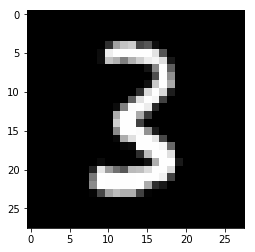

In [170]:
xb,yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

tensor(9)

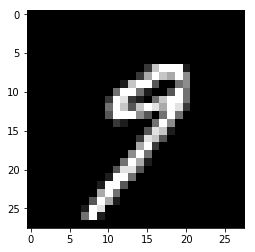

In [172]:
xb,yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

tensor(6)

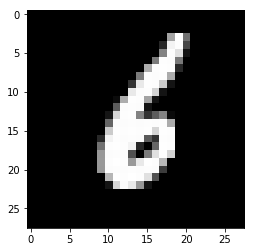

In [173]:
xb,yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

In [174]:
model,opt = get_model()
fit()

loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.4408, grad_fn=<NllLossBackward>), tensor(0.8906))

### PyTorch DataLoader

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=4171)

In [ ]:
#export
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

In [ ]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)

In [ ]:
model,opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.2196, grad_fn=<NllLossBackward>), tensor(0.9375))

PyTorch's defaults work fine for most things however:

In [ ]:
train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True)
valid_dl = DataLoader(valid_ds, bs, shuffle=False)

In [ ]:
model,opt = get_model()
fit()

loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.1029, grad_fn=<NllLossBackward>), tensor(0.9688))

Note that PyTorch's `DataLoader`, if you pass `num_workers`, will use multiple threads to call your `Dataset`.

## Validation

You **always** should also have a [validation set](http://www.fast.ai/2017/11/13/validation-sets/), in order to identify if you are overfitting.

We will calculate and print the validation loss at the end of each epoch.

(Note that we always call `model.train()` before training, and `model.eval()` before inference, because these are used by layers such as `nn.BatchNorm2d` and `nn.Dropout` to ensure appropriate behaviour for these different phases.)

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=4260)

In [ ]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        # Handle batchnorm / dropout
        model.train()
#         print(model.training)
        for xb,yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
#         print(model.training)
        with torch.no_grad():
            tot_loss,tot_acc = 0.,0.
            for xb,yb in valid_dl:
                pred = model(xb)
                tot_loss += loss_func(pred, yb)
                tot_acc  += accuracy (pred,yb)
        nv = len(valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
    return tot_loss/nv, tot_acc/nv

*Question*: Are these validation results correct if batch size varies?

`get_dls` returns dataloaders for the training and validation sets:

In [ ]:
#export
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))

Now, our whole process of obtaining the data loaders and fitting the model can be run in 3 lines of code:

In [ ]:
train_dl,valid_dl = get_dls(train_ds, valid_ds, bs)
model,opt = get_model()
loss,acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

0 tensor(0.1573) tensor(0.9533)
1 tensor(0.5863) tensor(0.8684)
2 tensor(0.1299) tensor(0.9609)
3 tensor(0.1178) tensor(0.9664)
4 tensor(0.1283) tensor(0.9625)


In [ ]:
assert acc>0.9

## Export

In [ ]:
!python notebook2script.py 03_minibatch_training.ipynb

Converted 03_minibatch_training.ipynb to nb_03.py
